In [1]:

from qiskit import QuantumCircuit

# This is the simple circuit we will run if the CHSH test passes
# It creates a Bell state and measures both qubits
pli_plus = QuantumCircuit(2, 2)
pli_plus.h(0)
pli_plus.cx(0, 1)
pli_plus.measure([0, 1], [0, 1])

/var/folders/jm/g1b9sjb97797vbll5bqqm67w0000gn/T/ipykernel_67180/830813296.py:1: DeprecationWarning: Using Qiskit with Python 3.9 is deprecated as of the 2.1.0 release. Support for running Qiskit with Python 3.9 will be removed in the 2.3.0 release, which coincides with when Python 3.9 goes end of life.
  from qiskit import QuantumCircuit


In [ ]:
reps = 100
delay_between_reps = 6 * 1  # Every six seconds; change this if you are using a real backend 
introspection_shots = 1024
main_circuit_shots = 1024
entanglement_threshold = 1.9 # CHSH score above which we consider the backend to be entangling - 2.8 in Aer simulator

In [3]:
from qonscious.adapters.aer_sampler_adapter import AerSamplerAdapter
from qonscious.adapters.backend_adapter import BackendAdapter
from qonscious.adapters.ibm_sampler_adapter import IBMSamplerAdapter

# Uncomment this line to use the Aer simulator instead of a real
backend_adapter = AerSamplerAdapter()

# Uncomment these lines to use a real backend instead of the Aer simulator
# ibm_token = os.getenv("IBM_QUANTUM_TOKEN")
# backend_adapter = IBMSamplerAdapter.least_busy_backend(ibm_token)

/Users/casco/Development/lifia-qonscious/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/jm/g1b9sjb97797vbll5bqqm67w0000gn/T/ipykernel_67180/164989140.py:6: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  backend_adapter = AerSamplerAdapter()


In [4]:

from typing import TYPE_CHECKING, cast

if TYPE_CHECKING:
    from core.types import ScorableFigureOfMeritResult

from qonscious.core.types import FigureOfMeritResult


def on_pass(backend_adapter : BackendAdapter, figure_of_merit_results: list[FigureOfMeritResult]):
    chsh_score = cast("ScorableFigureOfMeritResult",figure_of_merit_results[0])["score"]
    print(f"Entanglement passed with score: {chsh_score}")
    print("Running main circuit (creating a Bell state and measuring it)...")
    run_result = backend_adapter.run(pli_plus, shots=main_circuit_shots)
    print("Main circuit run complete.")
    return run_result

def on_fail(backend_adapter : BackendAdapter, figure_of_merit_results: list[FigureOfMeritResult]):
    chsh_score = cast("ScorableFigureOfMeritResult",figure_of_merit_results[0])["score"]
    print(f"Skipping main circuit - entanglement score was {chsh_score}")
    return None


In [5]:
from qonscious.core.merit_compliance_check import MeritComplianceCheck
from qonscious.foms.packed_chsh import PackedCHSHTest


def chsh_score_over(threshold: float):
    return lambda r: cast("ScorableFigureOfMeritResult", r)["score"] > threshold

check_chsh_is_ok = check = MeritComplianceCheck(
    figure_of_merit=PackedCHSHTest(),
    decision_function=chsh_score_over(2.0), # In the Aer simulator we can get up to 2.828
)

In [6]:


import time

from qonscious.core.executor import run_conditionally

results = []

for i in range(reps):
    print(f"{i+1}. Running figure of merit checks + conditional execution")
    qonscious_result = run_conditionally(
    backend_adapter=backend_adapter,
    checks= [check_chsh_is_ok],
    on_pass=on_pass,
    on_fail=on_fail,
    shots=2048
    )
    results.append(qonscious_result)
    if i < reps - 1:
        time.sleep(delay_between_reps)

1. Running figure of merit checks + conditional execution
Entanglement passed with score: 2.8134765625
Running main circuit (creating a Bell state and measuring it)...
Main circuit run complete.
2. Running figure of merit checks + conditional execution
Entanglement passed with score: 2.8173828125
Running main circuit (creating a Bell state and measuring it)...
Main circuit run complete.
3. Running figure of merit checks + conditional execution
Entanglement passed with score: 2.8466796875
Running main circuit (creating a Bell state and measuring it)...
Main circuit run complete.
4. Running figure of merit checks + conditional execution
Entanglement passed with score: 2.83984375
Running main circuit (creating a Bell state and measuring it)...
Main circuit run complete.
5. Running figure of merit checks + conditional execution
Entanglement passed with score: 2.853515625
Running main circuit (creating a Bell state and measuring it)...
Main circuit run complete.
6. Running figure of merit c

KeyboardInterrupt: 

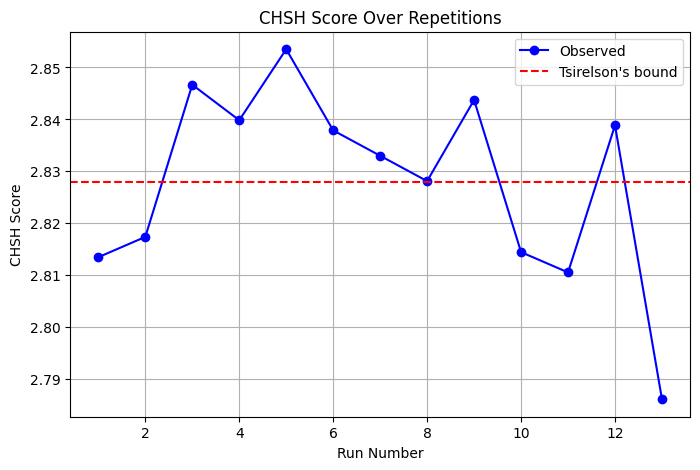

In [8]:
import matplotlib.pyplot as plt

chsh_scores = [result["figures_of_merit_results"][0]["score"] for result in results]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(chsh_scores)+1), chsh_scores, marker='o', linestyle='-', color='b', label="Observed")

# Add Tsirelson’s bound
tsirelson_bound = 2.828
plt.axhline(tsirelson_bound, color='r', linestyle='--', label="Tsirelson's bound")

plt.title("CHSH Score Over Repetitions")
plt.xlabel("Run Number")
plt.ylabel("CHSH Score")
# plt.ylim(bottom=0)   # start y-axis at 0
# plt.ylim(top=3)
plt.grid(True)
plt.legend()
plt.show()

In [19]:
results[0]["experiment_result"]

{'counts': {'11': 512, '00': 512},
 'shots': 1024,
 'backend_properties': {'name': 'aer_simulator'},
 'timestamps': {'created': '2025-08-31T02:04:07.345845+00:00',
  'running': '2025-08-31T02:04:07.346051+00:00',
  'finished': '2025-08-31T02:04:07.401851+00:00'},
 'raw_results': SamplerResult(quasi_dists=[{3: 0.5, 0: 0.5}], metadata=[{'shots': 1024, 'simulator_metadata': {'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 10, 'parallel_shots': 1, 'sample_measure_time': 0.000257709, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1], 'device': 'CPU', 'time_taken': 0.000511417, 'measure_sampling': True, 'num_clbits': 2, 'max_memory_mb': 24576, 'input_qubit_map': [[1, 1], [0, 0]], 'num_qubits': 2, 'method': 'stabilizer', 'required_memory_mb': 0, 'fusion': {'enabled': False}}}])}

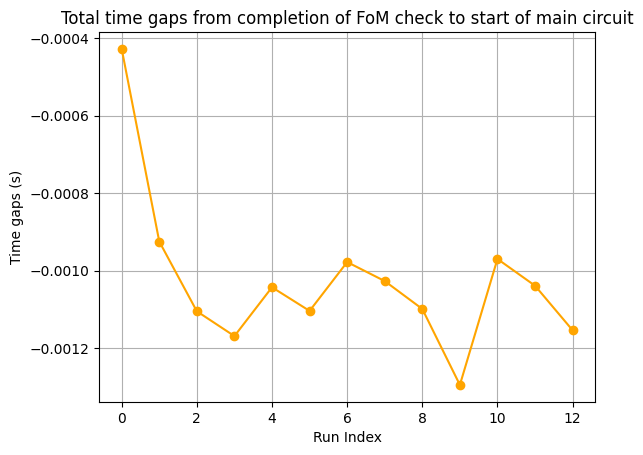

In [20]:
from datetime import datetime

import matplotlib.pyplot as plt


def parse_utc(s):
    return datetime.fromisoformat(s.replace("Z", "+00:00"))

time_gaps = [
    (parse_utc(result["figures_of_merit_results"][0]["experiment_result"]["timestamps"]["finished"]) -
     parse_utc(result["experiment_result"]["timestamps"]["running"])).total_seconds()
    for result in results
]

plt.figure()
plt.plot(range(len(time_gaps)), time_gaps, marker='o', color='orange')
plt.title("Total time gaps from completion of FoM check to start of main circuit")
plt.xlabel("Run Index")
plt.ylabel("Time gaps (s)")
plt.grid(True)
plt.show()

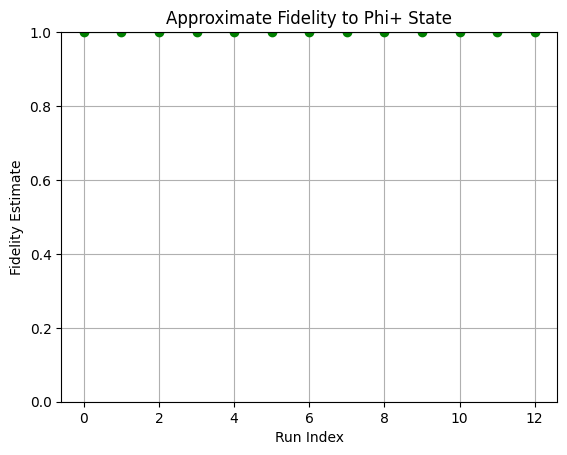

In [ ]:
def phi_plus_fidelity(counts):
    shots = sum(counts.values())
    prob_00 = counts.get("00", 0) / shots
    prob_11 = counts.get("11", 0) / shots
    # For ideal \Phi^+, the off-diagonal terms contribute too, but from counts only, we approximate fidelity
    return prob_00 + prob_11  # coarse classical fidelity estimate

fidelities = [phi_plus_fidelity(result["experiment_result"]["counts"]) for result in results]

plt.figure()
plt.plot(range(len(fidelities)), fidelities, marker='o', color='green')
plt.title("Approximate Fidelity to Phi+ State")
plt.xlabel("Run Index")
plt.ylabel("Fidelity Estimate")
plt.grid(True)
plt.ylim(0, 1)
plt.show()


In [ ]:
# TODO: fix this cell to the new structure of results

import json

import pandas as pd

# Save experiment data in a tabular summary
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
csv_filename = f"experiment_summary_{timestamp}.csv"

df = pd.DataFrame([{
    'introspection_created': r.get('introspection', {}).get('timestamps', {}).get('created'),
    'introspection_running': r.get('introspection', {}).get('timestamps', {}).get('running'),
    'introspection_finished': r.get('introspection', {}).get('timestamps', {}).get('finished'),
    'execution_created': r.get('execution', {}).get('timestamps', {}).get('created'),
    'execution_running': r.get('execution', {}).get('timestamps', {}).get('running'),
    'execution_finished': r.get('execution', {}).get('timestamps', {}).get('finished'),    
    'entanglement_score': r.get('entanglement_score'),
    'execution_counts': json.dumps(r.get('execution', {}).get('counts')) if r.get('execution') else None
} for r in results])
df.to_csv(csv_filename, index=False)